In [1]:
import os
import sys
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from pprint import pprint
import torch
sys.path.append('..')
sys.path.append('/home/valerie/Projects/Alps_LCC/models')
print(sys.path)

import torch
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from models.ACE_Better_DeepLabV3Plus import ACE_deeplabv3P_w_Better_Experts
from argparse import Namespace
from dataset.SwissImageDataset import SwissImage
from torch.utils.data import DataLoader
torch.set_grad_enabled(False) 
from torch.nn.functional import softmax


['/home/valerie/Projects/Alps_LCC/notebook', '/home/valerie/anaconda3/envs/ace/lib/python311.zip', '/home/valerie/anaconda3/envs/ace/lib/python3.11', '/home/valerie/anaconda3/envs/ace/lib/python3.11/lib-dynload', '', '/home/valerie/anaconda3/envs/ace/lib/python3.11/site-packages', '..', '/home/valerie/Projects/Alps_LCC/models']


In [3]:
config_fp ='/home/valerie/Projects/Alps_LCC/out/experts/ace_3exp_30June/config.json'
checkpoint_path = '/home/valerie/Projects/Alps_LCC/out/experts/ace_3exp_30June/current_best.pt'
# Open the JSON file and load its contents as a dictionary
with open(config_fp, 'r') as json_file:
    cfg = json.load(json_file)
    args = Namespace(**cfg)
    pprint(cfg)
checkpoint = torch.load(checkpoint_path)
pprint(checkpoint.keys())

{'CNN_aggregator': False,
 'L2penalty': False,
 'MLP_aggregator': False,
 'bs': 64,
 'debug': False,
 'device': 'cuda',
 'epoch': 50,
 'experts': 3,
 'force_cpu': False,
 'log_wandb': True,
 'loss': 'celoss',
 'lr': 1e-05,
 'lr_decay_rate': 0.1,
 'lws': False,
 'model': 'Deeplabv3_w_Better_Experts',
 'name': 'ace_3exp_30June',
 'num_workers': 16,
 'out_dir': 'out/baseline/',
 'seed': 2436,
 'separate_backprop': False,
 'small_dataset': True,
 'step_size': 10,
 'test_only': False,
 'weight_decay': 0.01}
dict_keys(['epoch', 'state_dict', 'perf', 'last_epoch', 'optimizer'])


In [4]:
model = ACE_deeplabv3P_w_Better_Experts(num_classes=10,num_experts=args.experts, pretrained_backbone=True,use_lws=True,)
model.load_state_dict(checkpoint['state_dict'])
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
model = model.to(device)

In [5]:
# Look at the manĝnitude of the weights and of the logits per experts : 

w_0 = model.classifier.SegHead_many[3].weight.squeeze()
print(torch.norm(w_0,dim=1))


w_1 = model.classifier.SegHead_few[3].weight.squeeze()
print(torch.norm(w_1,dim=1))



w_2 = model.classifier.SegHead_medium[3].weight.squeeze()
print(torch.norm(w_2,dim=1))



tensor([0.5867, 0.6695, 0.6321, 0.6618, 0.6182, 0.6526, 0.6526, 0.6581, 0.7199,
        0.6902], device='cuda:0')
tensor([0.5594, 0.5884, 0.5710, 0.5843, 0.5851, 0.6028, 0.5900, 0.5896, 0.5824,
        0.5996], device='cuda:0')
tensor([0.5755, 0.5710, 0.5356, 0.5604, 0.5906, 0.5842, 0.5588, 0.5881, 0.5660,
        0.5851], device='cuda:0')


In [49]:
input = torch.rand([8,4,200,200]).to(device)


In [50]:
out = model(input)

In [51]:
out['exp_0'].shape,out['exp_1'].shape,out['exp_2'].shape

(torch.Size([8, 10, 200, 200]),
 torch.Size([8, 10, 200, 200]),
 torch.Size([8, 10, 200, 200]))

In [52]:
v_0 = out['exp_0'].mean(dim=[0,2,3]).cpu().numpy()
v_1 = out['exp_1'].mean(dim=[0,2,3]).cpu().numpy()
v_2 = out['exp_2'].mean(dim=[0,2,3]).cpu().numpy()

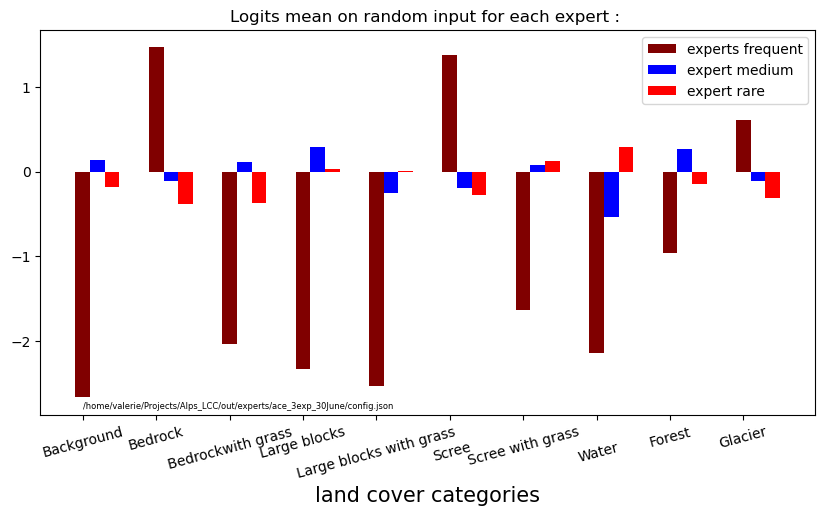

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
# Set position of bar on X axis
barWidth =0.2
br1 = np.arange(len(v_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# creating the bar plot
plt.bar(br1,v_0, color ='maroon',  width = barWidth, label ='experts frequent' )
plt.bar(br2,v_1, color ='blue',  width = barWidth , label ='expert medium')
plt.bar(br3,v_2, color ='red',  width = barWidth, label ='expert rare' )
plt.title('Logits mean on random input for each expert : ')
plt.xlabel('land cover categories',  fontsize = 15)
plt.xticks(range(10),['Background', "Bedrock", "Bedrockwith grass", "Large blocks", "Large blocks with grass", "\nScree",  "Scree with grass","\nWater", "Forest" , "Glacier" ,],rotation =15)
plt.text(x=0,y=-2.8,s=config_fp,fontsize = 6)
plt.legend()
plt.show()

# same on a different model :

In [85]:
config_fp ='/home/valerie/Projects/Alps_LCC/out/separate_bckprp/ace_3exp_L2_new_lws_separate_bckprp/config.json'
checkpoint_path = '/home/valerie/Projects/Alps_LCC/out/separate_bckprp/ace_3exp_L2_new_lws_separate_bckprp/current_best.pt'
# Open the JSON file and load its contents as a dictionary
with open(config_fp, 'r') as json_file:
    cfg = json.load(json_file)
    args = Namespace(**cfg)
    pprint(cfg)
checkpoint = torch.load(checkpoint_path)
pprint(checkpoint.keys())

{'CNN_aggregator': False,
 'L2penalty': True,
 'MLP_aggregator': False,
 'bs': 64,
 'debug': False,
 'device': 'cuda',
 'epoch': 75,
 'experts': 3,
 'force_cpu': False,
 'log_wandb': True,
 'loss': 'celoss',
 'lr': 1e-05,
 'lr_decay_rate': 0.1,
 'lws': True,
 'model': 'Deeplabv3_w_Better_Experts',
 'name': 'ace_3exp_L2_new_lws_separate_bckprp',
 'num_workers': 16,
 'out_dir': 'out/separate_bckprp/',
 'seed': 2436,
 'separate_backprop': True,
 'small_dataset': True,
 'step_size': 10,
 'test_only': False,
 'weight_decay': 0.01}
dict_keys(['epoch', 'state_dict', 'perf', 'last_epoch', 'optimizer'])


In [86]:
model = ACE_deeplabv3P_w_Better_Experts(num_classes=10,num_experts=args.experts, pretrained_backbone=True,use_lws=True,)
model.load_state_dict(checkpoint['state_dict'])
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
model = model.to(device)

In [88]:
# Look at the manĝnitude of the weights and of the logits per experts : 

w_0 = model.classifier.SegHead_many[3].weight.squeeze()
print(torch.norm(w_0,dim=1))

w_1 = model.classifier.SegHead_few[3].weight.squeeze()
print(torch.norm(w_1,dim=1))

w_2 = model.classifier.SegHead_medium[3].weight.squeeze()
print(torch.norm(w_2,dim=1))

tensor([0.4176, 0.7203, 0.5676, 0.5440, 0.4707, 0.7067, 0.6148, 0.5664, 0.7373,
        0.7703], device='cuda:0')
tensor([0.5594, 0.5884, 0.5710, 0.5843, 0.5850, 0.6028, 0.5899, 0.5895, 0.5824,
        0.5996], device='cuda:0')
tensor([0.5750, 0.5659, 0.5353, 0.5596, 0.5847, 0.5763, 0.5582, 0.5807, 0.5652,
        0.5791], device='cuda:0')


In [99]:
input = torch.rand([64,4,50,500]).to(device)
out = model(input)
print(out.keys())

dict_keys(['exp_0', 'exp_1', 'exp_2'])


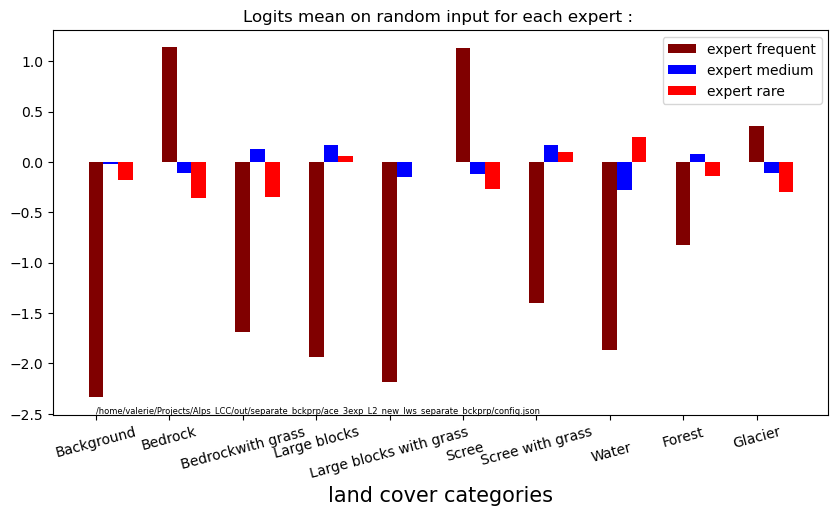

In [100]:
v_0 = out['exp_0'].mean(dim=[0,2,3]).cpu().numpy()
v_1 = out['exp_1'].mean(dim=[0,2,3]).cpu().numpy()
v_2 = out['exp_2'].mean(dim=[0,2,3]).cpu().numpy()


fig = plt.figure(figsize = (10, 5))
# Set position of bar on X axis
barWidth =0.2
br1 = np.arange(len(v_0))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# creating the bar plot
plt.bar(br1,v_0, color ='maroon',  width = barWidth, label ='expert frequent' )
plt.bar(br2,v_1, color ='blue',  width = barWidth , label ='expert medium')
plt.bar(br3,v_2, color ='red',  width = barWidth, label ='expert rare' )
plt.title('Logits mean on random input for each expert : ')
plt.xlabel('land cover categories',  fontsize = 15)
plt.xticks(range(10),['Background', "Bedrock", "Bedrockwith grass", "Large blocks", "Large blocks with grass", "\nScree",  "Scree with grass","\nWater", "Forest" , "Glacier" ,],rotation =15)
plt.text(x=0,y=-2.5,s=config_fp,fontsize = 6)
plt.legend()
plt.show()